# GAN Condicional

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [37]:
class CGAN:
  def __init__(self, image_shape=(28,28,1)):
    self.num_labels = 10
    self.latent_vector = (100,)
    self.image_shape = image_shape
    self.inputs = layers.Input(shape=self.latent_vector)
    self.l_inputs = layers.Input(shape=(self.num_labels,))
    self.generator = self.build_generator(self.inputs, self.l_inputs, image_shape[0])
    inputs = layers.Input(shape=image_shape)
    l_inputs = layers.Input(shape=(self.num_labels,))
    self.discriminator = self.build_discriminator(inputs, l_inputs)

  @staticmethod
  def build_generator(inputs, labels, image_shape):
    img_r = image_shape//4
    kernels = [128, 64, 32, 1]
    kernel_size = 5
    x = layers.Concatenate()([inputs, labels])
    x = layers.Dense(img_r*img_r*kernels[0])(x)
    x = layers.Reshape((img_r,img_r,kernels[0]))(x)
    for kernel in kernels:
      if kernel >= kernels[1]:
        strides=2
      else:
        strides=1
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Conv2DTranspose(kernel, kernel_size, strides=strides, padding='same')(x)
    x = layers.Activation('sigmoid')(x)
    generator = keras.Model([inputs, labels], x, name='Generator')
    return generator
  
  def build_discriminator(self,inputs, labels):
    kernels = [32,64,128,256]
    kernel_size = 5
    x = inputs
    y = layers.Dense(self.image_shape[0]**2)(labels)
    y = layers.Reshape((self.image_shape[0],self.image_shape[0],1))(y)
    x = layers.Concatenate()([x,y])
    for kernel in kernels:
      if kernel >= kernels[1]:
        strides=2
      else:
        strides=1
      x = layers.LeakyReLU()(x)
      x = layers.Conv2D(kernel, kernel_size, strides=strides, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    discriminator = keras.Model([inputs, labels], x, name='Discriminator')
    return discriminator

  def compile(self):
    lr = 1e-4
    decay = 5e-8
    optimizer = optimizers.Adam(lr, decay=decay)
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    self.discriminator.trainable=False
    self.adversarial = keras.Model([self.inputs, self.l_inputs], self.discriminator([self.generator([self.inputs, self.l_inputs]), self.l_inputs]))
    optimizer = optimizers.Adam(lr*0.5, decay=decay*0.5)
    self.adversarial.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    self.adversarial.summary()

  def train(self, data, batch_size, epochs):
    input_noise = np.random.uniform(-1.0, 1.0, size=[64, self.latent_vector[0]])
    X, Y = data
    X_size = X.shape[0]
    steps = X_size//batch_size
    for e in range(epochs):
      lossD, accD = 0, 0
      lossA, accA = 0, 0
      for i in range(steps):
        random_idx = np.random.randint(0, X_size, size=batch_size)
        real_imgs = X[random_idx]
        real_labels = Y[random_idx]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_vector[0]])
        fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels, batch_size)]
        fake_imgs = self.generator.predict([noise, fake_labels])

        # Creamos el conjunto de datos 
        x = np.concatenate((real_imgs, fake_imgs))
        # Etiquetamos
        y = np.ones([2*batch_size, 1])
        y[batch_size:,:] = 0.0
        labels = np.concatenate((real_labels, fake_labels))
        # Entrenamiento del discriminador
        lossd, accd = self.discriminator.train_on_batch([x, labels],y)
        lossD += lossd
        accD += accd
        # Entramiento del adversarial
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_vector[0]])
        fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels, batch_size)]
        y = np.ones([batch_size, 1])
        lossa, acca = self.adversarial.train_on_batch([noise, fake_labels],y)
        lossA += lossa
        accA += acca
      lossD, accD = lossD/steps, accD/steps
      lossA, accA = lossA/steps, accA/steps
      print("Step {}: [D] Loss:{}, Acc:{}".format(e,lossD,accD))
      print("Step {}: [A] Loss:{}, Acc:{}".format(e,lossA,accA))
      self.generator.save('Generator_e{}.h5'.format(e+1))
      # Graficar imagenes
      noise = np.random.uniform(-1.0, 1.0, size=[25, self.latent_vector[0]])
      fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels, 25)]
      fig, ax = plt.subplots(5,5)
      fake_imgs = self.generator.predict([noise,fake_labels])
      for i in range(5):
        for j in range(5):
          ax[i,j].imshow(fake_imgs[i+5*j,:,:,0])
          print("({},{}): {}".format(i,j,fake_labels[i+5*j]))
      plt.show()
      
  
  def load_mnist(self):
    (X,Y), (_,_) = mnist.load_data()
    w,h,c = self.image_shape
    X = X.reshape((-1,w,h,c))
    self.X = X.astype('float32')/255
    self.Y = to_categorical(Y) 
    return self.X, self.Y

In [38]:
cgan = CGAN()

In [39]:
cgan.compile()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 Generator (Functional)         (None, 28, 28, 1)    1364225     ['input_41[0][0]',               
                                                                  'input_42[0][0]']               
                                                                                                  
 Discriminator (Functional)     (None, 1)            1348177     ['Generator[0][0]',        

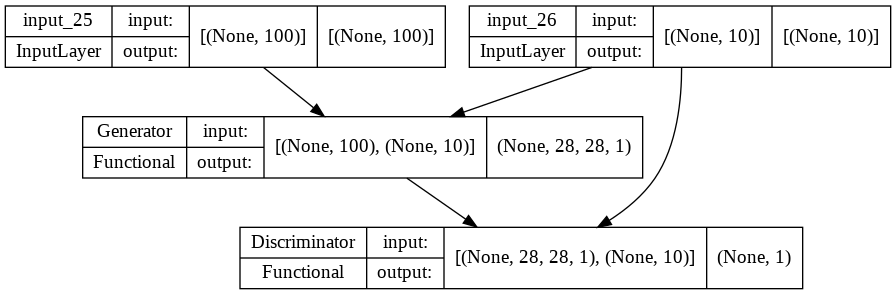

In [24]:
plot_model(cgan.adversarial, show_shapes=True)

In [40]:
X,Y = cgan.load_mnist()

Step 0: [D] Loss:0.09337330245425901, Acc:0.9704759204909285
Step 0: [A] Loss:1.31707539312991, Acc:0.6799793223052295


(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


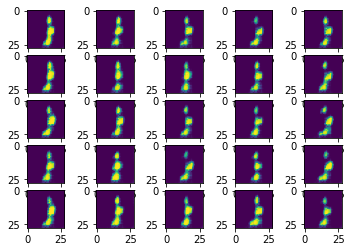

Step 1: [D] Loss:0.05830038852088804, Acc:0.9816235325506937
Step 1: [A] Loss:1.4766622235778744, Acc:0.59375


(0,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


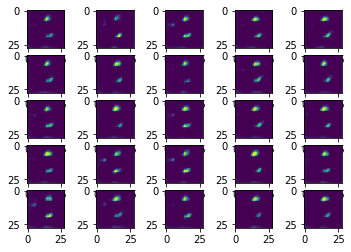

Step 2: [D] Loss:0.056348784691129764, Acc:0.9825073372465315
Step 2: [A] Loss:1.357250964091987, Acc:0.6399413020277481


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


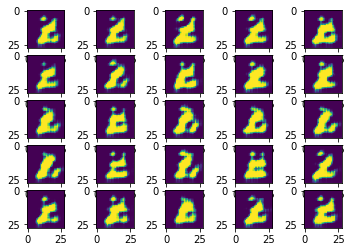

Step 3: [D] Loss:0.0825030868930773, Acc:0.9729605789754536
Step 3: [A] Loss:1.7065445754425859, Acc:0.5172258537886874


(0,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


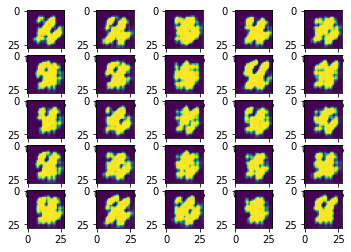

Step 4: [D] Loss:0.1599505963866545, Acc:0.9397928895410885
Step 4: [A] Loss:2.526211233511408, Acc:0.22070104055496265


(0,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


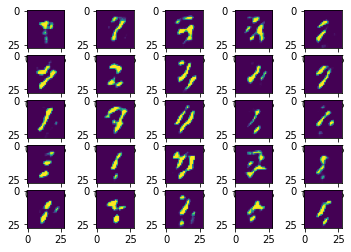

Step 5: [D] Loss:0.23847080321869193, Acc:0.9058414487726788
Step 5: [A] Loss:2.3433653617490444, Acc:0.16050226787620064


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


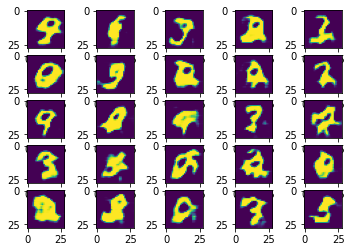

Step 6: [D] Loss:0.2622151230615956, Acc:0.8938850720384205
Step 6: [A] Loss:2.351306757524912, Acc:0.10642342582710779


(0,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


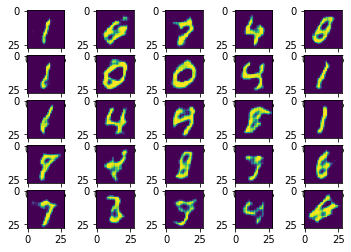

Step 7: [D] Loss:0.3122127441134753, Acc:0.867571037886873
Step 7: [A] Loss:2.1442826132000827, Acc:0.13373799359658484


(0,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


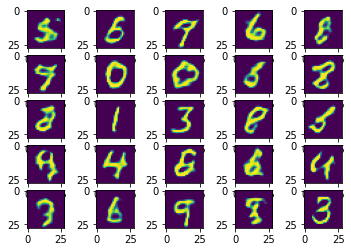

Step 8: [D] Loss:0.37980034401920587, Acc:0.8316435432230523
Step 8: [A] Loss:1.7580289097071458, Acc:0.16615528281750266


(0,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


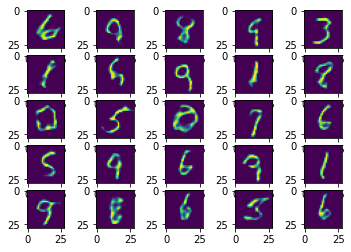

Step 9: [D] Loss:0.4195384442519989, Acc:0.8073305763073639
Step 9: [A] Loss:1.6208370193727752, Acc:0.19000133404482392


(0,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


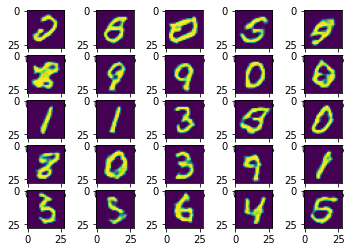

Step 10: [D] Loss:0.4630198708338824, Acc:0.7808080976520811
Step 10: [A] Loss:1.4656166706548301, Acc:0.20137406616862327


(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


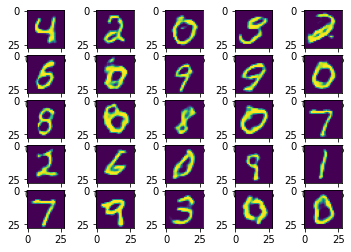

Step 11: [D] Loss:0.49018641787888273, Acc:0.758054295624333
Step 11: [A] Loss:1.358699238860111, Acc:0.22010072038420492


(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


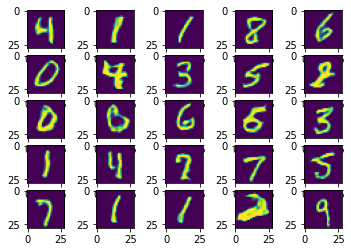

Step 12: [D] Loss:0.5114309889847848, Acc:0.7428795357524013
Step 12: [A] Loss:1.2601379355218902, Acc:0.22640408217716115


(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


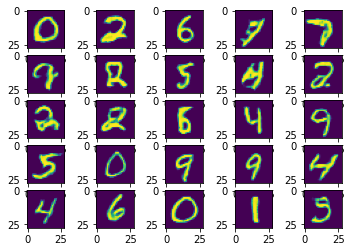

Step 13: [D] Loss:0.528679517251832, Acc:0.7255036019210246
Step 13: [A] Loss:1.2055264038362778, Acc:0.2507003735325507


(0,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


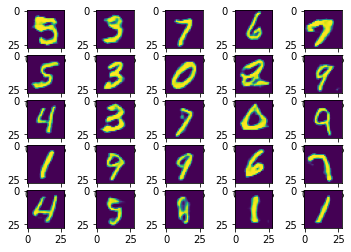

Step 14: [D] Loss:0.5445727728537841, Acc:0.7156650213447172
Step 14: [A] Loss:1.1530315465072176, Acc:0.2707443970117396


(0,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


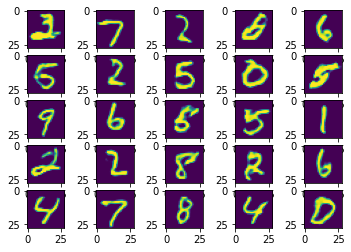

Step 15: [D] Loss:0.5587156208564021, Acc:0.7025663687299893
Step 15: [A] Loss:1.1018628707690326, Acc:0.2656750266808965


(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


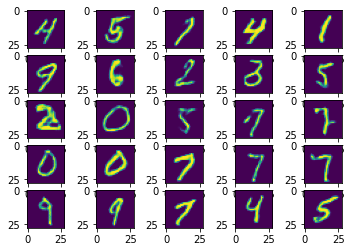

Step 16: [D] Loss:0.5668015927553431, Acc:0.6963797358591248
Step 16: [A] Loss:1.0595105555675837, Acc:0.29113860725720386


(0,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


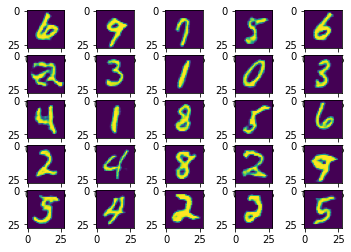

Step 17: [D] Loss:0.5755494459906917, Acc:0.6896511472785486
Step 17: [A] Loss:1.0468211621205097, Acc:0.28031616862326575


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


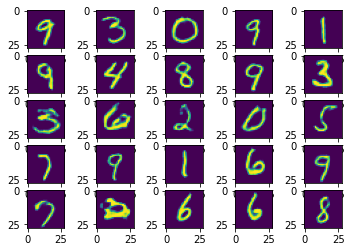

Step 18: [D] Loss:0.5857767937277526, Acc:0.6798625933831377
Step 18: [A] Loss:1.0119441638888518, Acc:0.301860992529349


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


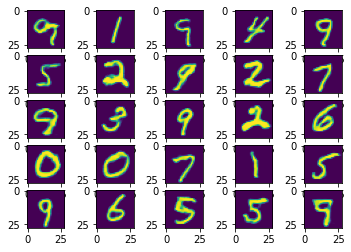

Step 19: [D] Loss:0.5896937403124195, Acc:0.6765858457844184
Step 19: [A] Loss:0.9818789245542874, Acc:0.3041455442902882


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


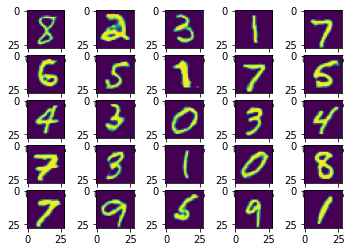

Step 20: [D] Loss:0.5933953426309176, Acc:0.6730172758804696
Step 20: [A] Loss:0.9893917358036103, Acc:0.3002101120597652


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


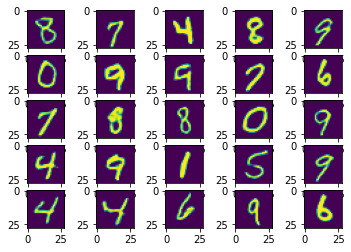

Step 21: [D] Loss:0.5918109934128972, Acc:0.6735675693703308
Step 21: [A] Loss:0.9861446227182573, Acc:0.29460712379935966


(0,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(3,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


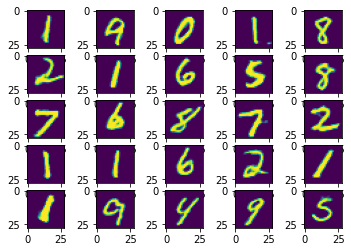

Step 22: [D] Loss:0.5950168830162688, Acc:0.6715748399146211
Step 22: [A] Loss:0.9815144709996251, Acc:0.30963180362860193


(0,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


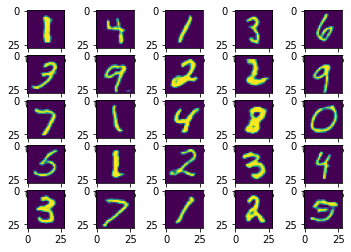

Step 23: [D] Loss:0.5917344836949539, Acc:0.6766858991462114
Step 23: [A] Loss:0.97948926152898, Acc:0.30773078975453577


(0,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(1,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


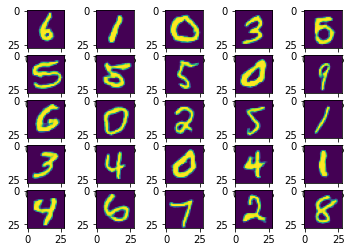

Step 24: [D] Loss:0.5832222753235218, Acc:0.6832977588046958
Step 24: [A] Loss:0.9985700046112851, Acc:0.30739727854855925


(0,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


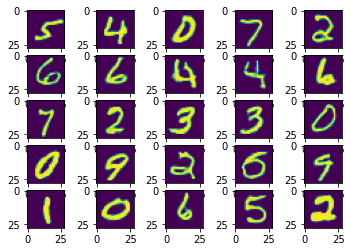

Step 25: [D] Loss:0.585109645554452, Acc:0.6823389140875133
Step 25: [A] Loss:0.9887151882895283, Acc:0.31370064034151546


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


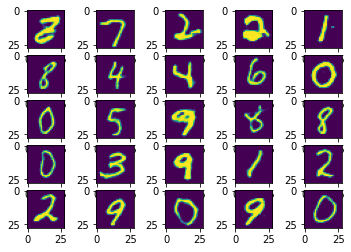

Step 26: [D] Loss:0.5790658534018436, Acc:0.688550560298826
Step 26: [A] Loss:1.0268579947910288, Acc:0.2959078175026681


(0,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(3,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


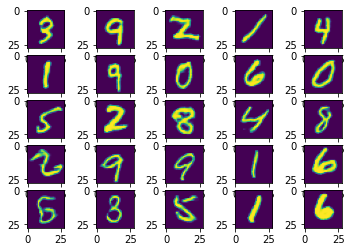

Step 27: [D] Loss:0.5728429464609417, Acc:0.6924609791889007
Step 27: [A] Loss:1.0417667951756888, Acc:0.2941402081109925


(0,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


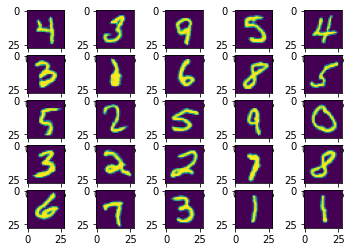

Step 28: [D] Loss:0.5671793102836405, Acc:0.6989310965848452
Step 28: [A] Loss:1.0662310503844645, Acc:0.2942402614727855


(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(0,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(2,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


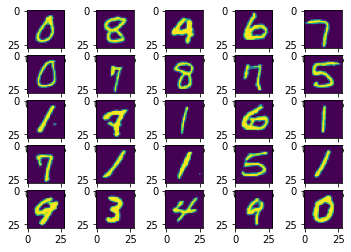

Step 29: [D] Loss:0.5674119527782676, Acc:0.6966965715048026
Step 29: [A] Loss:1.070796330557816, Acc:0.2886706243329776


(0,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(0,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,3): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,4): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,1): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,0): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(4,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


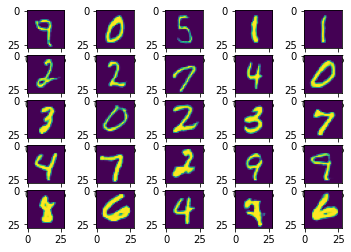

Step 30: [D] Loss:0.5625752228428486, Acc:0.7021744930629669
Step 30: [A] Loss:1.0907896839821734, Acc:0.2843016275346852


(0,0): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(0,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,3): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(0,4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(1,0): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(3,3): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(4,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


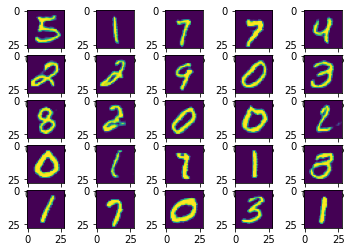

Step 31: [D] Loss:0.5601662374484246, Acc:0.7036919690501601
Step 31: [A] Loss:1.0961054481462582, Acc:0.2833677961579509


(0,0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(0,1): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(0,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(0,4): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(1,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,1): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,2): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(1,3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(1,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(2,0): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(2,1): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,2): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(2,3): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(2,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(3,0): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(3,1): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(3,2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
(3,3): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3,4): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(4,0): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(4,1): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(4,2): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(4,3): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(4,4): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


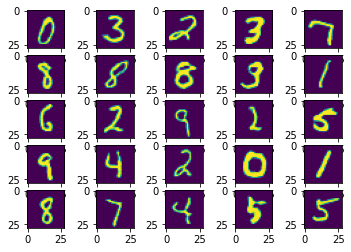

In [41]:
cgan.train((X, Y), 64, 32)

In [58]:
noise = np.random.uniform(-1., 1., size=[1, 100])
label = np.zeros(shape=(1,10))
n = 2
label[0,n] = 1.

In [59]:
predict = cgan.generator([noise, label])

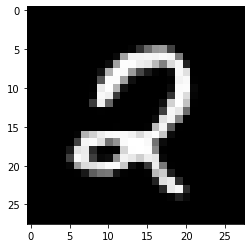

In [60]:
plt.imshow(predict[0,:,:,0], cmap='gray')